In [2]:
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
import os
import numpy as np
import matplotlib.pyplot as plt

latest execution

In [3]:
print(datetime.now())

2021-03-24 22:10:54.685129


In [3]:
today=datetime.now().date()
today_string=today.strftime("%Y-%m-%d")
yesterday=today-timedelta(days=1)

In [4]:
covid_path=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..', 'RKI_COVID19_latest.csv.gz'))
impfmonitoring_path=os.path.normpath(os.path.join(os.path.abspath(''), '..', '..','Impfquotenmonitoring','raw_data', 'RKI_COVID19_Impfquotenmonitoring_latest.xlsx'))

### Daten einlesen

In [5]:
covid_df=pd.read_csv(covid_path, compression="gzip")

In [6]:
impfung_df=pd.read_excel(impfmonitoring_path,sheet_name="Impfungen_proTag",skipfooter=7)


#### Daten aufbereiten

In [7]:
covid_df["Meldedatum"]=pd.to_datetime(covid_df["Meldedatum"]).dt.date
covid_df["Refdatum"]=pd.to_datetime(covid_df["Refdatum"]).dt.date

In [8]:
impfung_df=impfung_df.dropna()
impfung_df["Datum"]=pd.to_datetime(impfung_df["Datum"]).dt.date

#### 7-Tage Inzidenz für Landkreis ERH

In [9]:
erh_df=covid_df[(covid_df["IdLandkreis"]==9572)]
erh_sum=erh_df[erh_df["NeuerFall"].isin([0,1,-1])].groupby("Meldedatum").agg({"AnzahlFall":"sum","Landkreis":"first"}).sort_values("Meldedatum",ascending=False)

count=0
sieben_tage=[]
stichtage=[]
for key, value in erh_sum.iterrows():
    count_current=0
    for i in range(0,7):
        date_current=key-timedelta(days=i)
        if date_current in erh_sum.index:
            count_current+=erh_sum.loc[date_current]["AnzahlFall"]     
    sieben_tage.append(count_current/1.372)
    stichtage.append(key+timedelta(days=1))
    count+=1
    if count>len(erh_sum)-7:
        break

sieben_tage=np.array(sieben_tage)
stichtage=np.array(stichtage)
for i in range(10):
    print(f"{stichtage[i]} --- {sieben_tage[i]:10.2f}")

2021-03-24 ---     119.53
2021-03-23 ---     112.24
2021-03-22 ---     117.35
2021-03-21 ---     112.97
2021-03-20 ---     113.70
2021-03-19 ---     106.41
2021-03-18 ---     107.14
2021-03-17 ---     106.41
2021-03-16 ---      92.57
2021-03-15 ---      86.73


### Plots

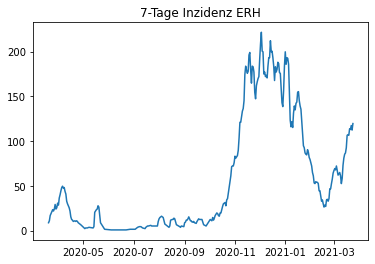

In [10]:
%matplotlib inline
plt.plot(stichtage, sieben_tage)
plt.title("7-Tage Inzidenz ERH")
plt.show()

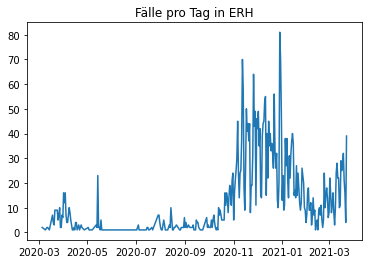

In [17]:
figure2=plt.plot(erh_sum.index,erh_sum.AnzahlFall)
plt.title("Fälle pro Tag in ERH")
plt.savefig('erh_faelle_pro_tag.png')
plt.show()

### Darstellung Deutschland

#### Bildung von kumulierten Summen

In [12]:
covid_sum=covid_df.groupby("Refdatum").agg({"AnzahlFall":"sum"}).sort_values("Refdatum",ascending=True)
covid_sum['Cum_sum']=covid_sum["AnzahlFall"].cumsum()

#### Bildung von kumulierten Summen der Impfungen

In [13]:
impfung_df['Cum_sum_1']=impfung_df["Erstimpfung"].cumsum()
impfung_df['Cum_sum_2']=impfung_df["Zweitimpfung"].cumsum()
impfung_df['Cum_sum_gesamt']=impfung_df["Gesamtzahl verabreichter Impfstoffdosen"].cumsum()

### Plot sum impfung + erkrankt

In [14]:
covid_sum_impfung=covid_sum[covid_sum.index.isin(impfung_df["Datum"])]

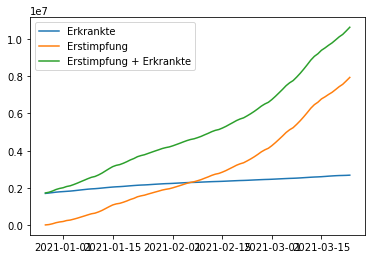

In [16]:
plt.plot(covid_sum_impfung.index,covid_sum_impfung["Cum_sum"], label="Erkrankte")
plt.plot(impfung_df["Datum"],impfung_df["Cum_sum_1"], label="Erstimpfung")
plt.plot(impfung_df["Datum"],impfung_df["Cum_sum_1"].to_numpy()+covid_sum_impfung["Cum_sum"].to_numpy(), label = "Erstimpfung + Erkrankte")
#plt.axhline(y=83020000*0.7, color='r', linestyle='-', label="Herdenimunität")
plt.legend()
plt.show()